# Using a pre-trained CNN

In [1]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "./cats_and_dogs_small"

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

datagen = ImageDataGenerator(rescale=1.0 / 255)
batch_size = 20


def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory, target_size=(150, 150), batch_size=batch_size, class_mode="binary"
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation="relu", input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5), loss="binary_crossentropy", metrics=["acc"]
)

history = model.fit(
    train_features,
    train_labels,
    epochs=10,
    batch_size=20,
    validation_data=(validation_features, validation_labels),
)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/10
2000/2000 [==============================] - 5s 2ms/step - loss: 0.5987 - acc: 0.6590 - val_loss: 0.4557 - val_acc: 0.8320
Epoch 2/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4215 - acc: 0.8175 - val_loss: 0.3624 - val_acc: 0.8690
Epoch 3/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3513 - acc: 0.8535 - val_loss: 0.3238 - val_acc: 0.8830
Epoch 4/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3179 - acc: 0.8665 - val_loss: 0.3028 - val_acc: 0.8860
Epoch 5/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2864 - acc: 0.8830 - val_loss: 0.2890 - val_acc: 0.8910
Epoch 6/10
2000/2000 [==============================] - 4s 2ms/step 

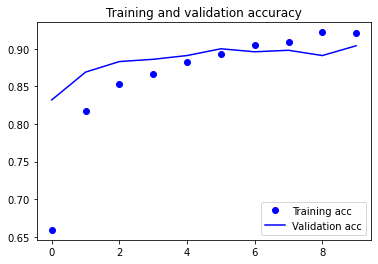

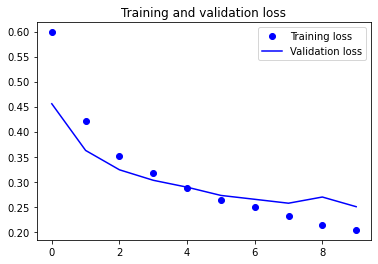

In [7]:
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
print(
    "This is the number of trainable weights " "before freezing the conv base:",
    len(model.trainable_weights),
)

This is the number of trainable weights before freezing the conv base: 30


In [11]:
conv_base.trainable = False

In [12]:
print(
    "This is the number of trainable weights " "after freezing the conv base:",
    len(model.trainable_weights),
)

This is the number of trainable weights after freezing the conv base: 4


In [13]:
from keras.preprocessing.image import ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

In [15]:
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [16]:
train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(150, 150),
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode="binary",
)

Found 2000 images belonging to 2 classes.


In [17]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir, target_size=(150, 150), batch_size=20, class_mode="binary"
)

Found 1000 images belonging to 2 classes.


In [18]:
model.compile(
    loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=2e-5), metrics=["acc"]
)

In [19]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2,
)

Epoch 1/5
 - 512s - loss: 0.5964 - acc: 0.6940 - val_loss: 0.4598 - val_acc: 0.8180
Epoch 2/5
 - 528s - loss: 0.4822 - acc: 0.7830 - val_loss: 0.3756 - val_acc: 0.8390
Epoch 3/5
 - 782s - loss: 0.4393 - acc: 0.8100 - val_loss: 0.3327 - val_acc: 0.8700
Epoch 4/5
 - 549s - loss: 0.4090 - acc: 0.8135 - val_loss: 0.3148 - val_acc: 0.8730
Epoch 5/5
 - 569s - loss: 0.3950 - acc: 0.8110 - val_loss: 0.2960 - val_acc: 0.8810


In [20]:
model.save("cats_and_dogs_small_3.h5")

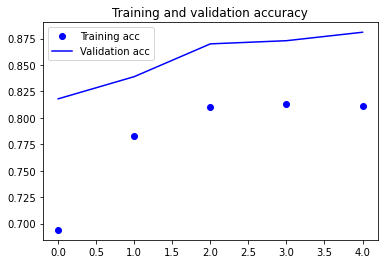

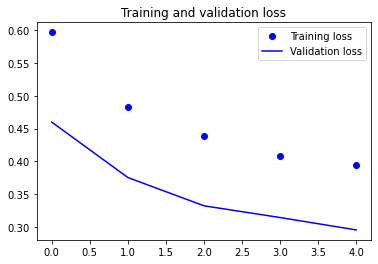

In [21]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## Fine-tuning

In [22]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [23]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [24]:
model.compile(
    loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=1e-5), metrics=["acc"]
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50,
)

Epoch 1/10
100/100 [==============================] - 693s 7s/step - loss: 0.3485 - acc: 0.8510 - val_loss: 0.2571 - val_acc: 0.8840
Epoch 2/10
100/100 [==============================] - 766s 8s/step - loss: 0.2962 - acc: 0.8730 - val_loss: 0.2127 - val_acc: 0.9120
Epoch 3/10
100/100 [==============================] - 809s 8s/step - loss: 0.2698 - acc: 0.8750 - val_loss: 0.1978 - val_acc: 0.9210
Epoch 4/10
100/100 [==============================] - 798s 8s/step - loss: 0.2650 - acc: 0.8890 - val_loss: 0.1741 - val_acc: 0.9350
Epoch 5/10
100/100 [==============================] - 788s 8s/step - loss: 0.2359 - acc: 0.9035 - val_loss: 0.2001 - val_acc: 0.9210
Epoch 6/10
100/100 [==============================] - 759s 8s/step - loss: 0.2056 - acc: 0.9150 - val_loss: 0.1677 - val_acc: 0.9370
Epoch 7/10
100/100 [==============================] - 714s 7s/step - loss: 0.2221 - acc: 0.9050 - val_loss: 0.1704 - val_acc: 0.9330
Epoch 8/10
100/100 [==============================] - 674s 7s/step - 

In [25]:
model.save("cats_and_dogs_small_4.h5")

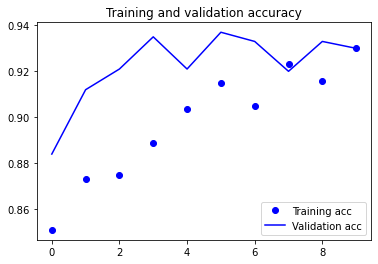

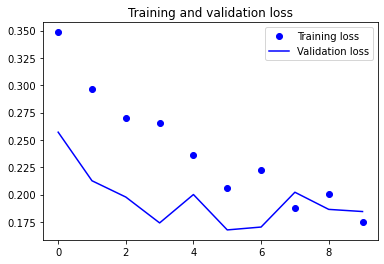

In [26]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

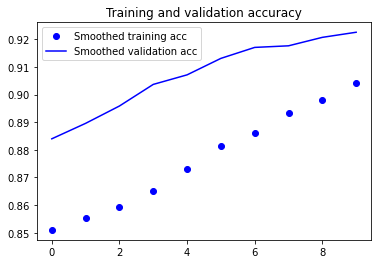

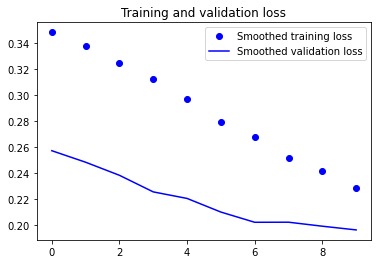

In [27]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


plt.plot(epochs, smooth_curve(acc), "bo", label="Smoothed training acc")
plt.plot(epochs, smooth_curve(val_acc), "b", label="Smoothed validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), "bo", label="Smoothed training loss")
plt.plot(epochs, smooth_curve(val_loss), "b", label="Smoothed validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [28]:
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=20, class_mode="binary"
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print("test acc:", test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9289999949932098
